### 解压数据
将文件下载到本地并进行解压。  
img压缩包解压成train和test两个文件夹，其中train目录下包含十个对应特征的文件夹。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import zipfile
from IPython.display import display
from PIL import Image

num_classes = 10
np.random.seed(133)

filename = "imgs.zip"

def maybe_extract(filename, force=True):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .zip
    print(root)
    if os.path.isdir('train') and os.path.isdir('test'):
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        zfile = zipfile.ZipFile(filename,'r')
        for filename in zfile.namelist():
            zfile.extract(filename, r'.')
        zfile.close()
    data_folders = [os.path.join('train', d) for d in sorted(os.listdir('train'))
                    if os.path.isdir(os.path.join('train', d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, ten per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

def dataset_size():
    
    size = 0
    for i in range(10):
        size += len([x for x in os.listdir(str(folders[i]))])
    print(size)
    return size

folders = maybe_extract(filename)
num_train = dataset_size()

imgs
imgs already present - Skipping extraction of imgs.zip.
['train/c0', 'train/c1', 'train/c2', 'train/c3', 'train/c4', 'train/c5', 'train/c6', 'train/c7', 'train/c8', 'train/c9']
22424


### 数据预处理
用PIL库中的Image函数调用open方法读取图片并转化为数组。

In [2]:
img_height = 640
img_width = 480

def load_image(folder):
    
    imgs = [i for i in os.listdir(folder)]
    num = len(imgs)
    data = np.zeros((num, img_width, img_height, 3), dtype='uint8')
    label = np.zeros((num,), dtype="uint8")
    for i in range(num):
        img = Image.open(folder+"/"+imgs[i])
        data[i,:,:,:] = np.asarray(img, dtype="uint8")
    label += int(folder.split("c")[1])           
    return data, label


合成一个包含10类别的训练集。  
c0：2489。   c5：2312。  
c1：2267。   c6：2325。  
c2：2317。   c7：2002。  
c3：2346。   c8：1911。   
c4：2326。   c9：2129。  

In [4]:
def merge_folder(folders):
    
    x_train = np.zeros((num_train, img_width, img_height, 3), dtype='uint8')
    y_train = np.zeros((num_train,), dtype="uint8")
    folders_size = 0
    for f in folders:
        print(f)
        data, label = load_image(f)
        folder_size = data.shape[0]
        folders_size += folder_size
        x_train[folders_size-folder_size:folders_size,:,:,:] = data
        y_train[folders_size-folder_size:folders_size] = label
    return x_train, y_train

x_train, y_train = merge_folder(folders)  

train/c0
train/c1
train/c2
train/c3
train/c4
train/c5
train/c6
train/c7
train/c8
train/c9


### Shuffle数据集
将合成数据集的顺序全部重新排列。
然后显示合成数据集的图片和标签对应的数组大小。

In [ ]:
r = np.random.permutation(len(y_train))
x_train = x_train[r,:,:,:] 
y_train = [r]
print(x_train.shape)
print(y_train.shape)

### 数据集可视化
随机选取15组图片，并对其进行可视化。确定所显示图片与标签正确对应。

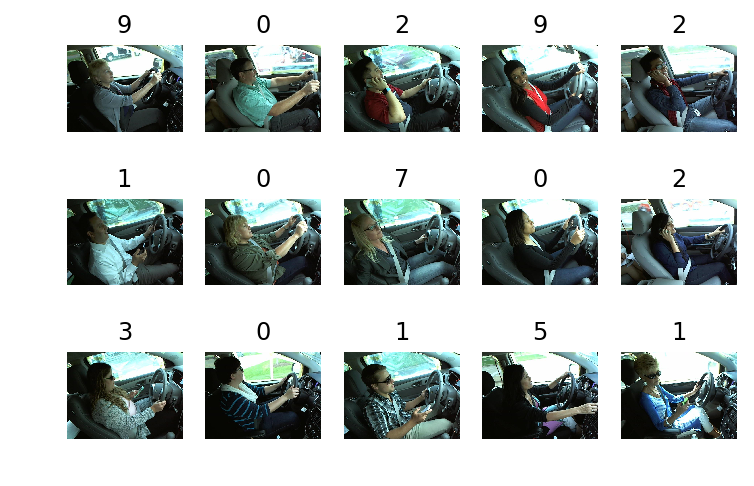

In [5]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

num_train = 22424

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, num_train-1)
    plt.title(str(y_train[index]))
    plt.imshow(x_train[index])
    plt.axis('off')


### 设计并测试一个模型架构

In [ ]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### 训练网络模型

In [ ]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))